# Integrate melting curve of pure MgSiO3
* use direct clapeyron slope integration
* electronic contribution ignored due to bug in adiabatic calculation

In [1]:
%run core.ipynb

analysis = load_analysis()
liq_eos_hybrid = analysis['liq_eos_hybrid']
liq_eos_S11 = analysis['liq_eos_S11']
liq_eos_dK09 = analysis['liq_eos_dK09']
sol_eos = analysis['sol_eos']

P_fus0 = analysis['P_fus0']
T_fus0 = analysis['T_fus0']
# dS_fus0 = analysis['dS_fus0']
# S_fus0 = analysis['S_fus0']


In [2]:
PT_fus_Stx09 = pd.read_csv('data/MgSiO3-pure-melt-curve-Stixrude2009.csv')

## Calculate melting curve

In [3]:
def melting_curve_deriv(P, TVlVs, liq_eos, sol_eos, dS_fus_kB=None):
    PV_ratio = xmeos.models.CONSTS['PV_ratio']
    T, Vliq, Vsol = TVlVs[0], TVlVs[1], TVlVs[2]
    # print('P', P, ', T', T, ', Vliq', Vliq, ', Vsol',Vsol)
    
    if dS_fus_kB is None:
        dS = liq_eos.entropy(Vliq, T) - sol_eos.entropy(Vsol, T)
    else:
        dS = dS_fus_kB*xmeos.models.CONSTS['kboltz']
        
    # print('   dS = ', dS)
    dV = Vliq - Vsol
     
    
    alpha_sol = sol_eos.thermal_exp(Vsol, T)
    alpha_liq = liq_eos.thermal_exp(Vliq, T)
    
    KT_sol = sol_eos.bulk_mod(Vsol, T)
    KT_liq = liq_eos.bulk_mod(Vliq, T)
    
    dTdP = dV/dS/PV_ratio
    # print('  dTdP = ', dTdP)
    dVdP_sol = Vsol*(alpha_sol*dTdP - 1.0/KT_sol)
    dVdP_liq = Vliq*(alpha_liq*dTdP - 1.0/KT_liq)
    TVV_deriv = np.hstack((dTdP, dVdP_liq, dVdP_sol))
    return TVV_deriv

In [4]:

def calc_melting_curve(Pinit, Tinit, liq_eos, sol_eos, 
                       Pmax=150.0, N=101, Vinit=9.0, dS_fus_kB=None):
    Vinit_liq = volume(Pinit, Tinit, liq_eos, Vinit=Vinit)
    Vinit_sol = volume(Pinit, Tinit, sol_eos)
    
    # print(liq_eos.press(Vinit_liq, Tinit))
    # print(sol_eos.press(Vinit_sol, Tinit))
    
    deriv_fun = lambda P, TVlVs, liq_eos=liq_eos, sol_eos=sol_eos, dS_fus_kB=dS_fus_kB: (
        melting_curve_deriv(P, TVlVs, liq_eos, sol_eos, dS_fus_kB=dS_fus_kB) )
    
    # Vinit = volume(Pinit, Tinit, eos, Vinit=Vinit_guess)
    # Vinit = eos.volume(Pinit, Tinit, Vinit_guess)
    
    P_path = np.linspace(Pinit, Pmax, N)
    output = sp.integrate.solve_ivp(deriv_fun, P_path[[0,-1]] , 
                                    np.array([Tinit, Vinit_liq, Vinit_sol]), 
                                    t_eval=P_path, vectorized=False)
    T_fus_pos, V_fus_liq_pos, V_fus_sol_pos = (
        output['y'][0], output['y'][1], output['y'][2])
    
    
    # P_path_neg = np.linspace(P_fus0, Pmin, N)
    # output_neg = sp.integrate.solve_ivp(deriv_fun, P_path_neg[[0,-1]] , 
    #                                 np.array([Vinit, Tinit]), 
    #                                 t_eval=P_path_neg, vectorized=True)
    # V_ad_neg, T_ad_neg = output_neg['y'][0], output_neg['y'][1]
    # 
    # P_ad = np.hstack((P_path_neg[::-1][:-1], P_path))
    # V_ad = np.hstack((V_ad_neg[::-1][:-1], V_ad_pos))
    # T_ad = np.hstack((T_ad_neg[::-1][:-1], T_ad_pos))
    
    P_fus = np.hstack((P_path))
    T_fus = np.hstack((T_fus_pos))
    V_fus_liq = np.hstack((V_fus_liq_pos))
    V_fus_sol = np.hstack((V_fus_sol_pos))
    
    return P_fus, T_fus, V_fus_liq, V_fus_sol
    

In [5]:
P_fus_S11, T_fus_S11, V_fus_liq_S11, V_fus_sol_S11 = calc_melting_curve(
    P_fus0, T_fus0, liq_eos_S11, sol_eos)
P_fus_dK09, T_fus_dK09, V_fus_liq_dK09, V_fus_sol_dK09 = calc_melting_curve(
    P_fus0, T_fus0, liq_eos_dK09, sol_eos)

dS_fus_kB = 1.5
P_fus_S11_fix, T_fus_S11_fix, V_fus_liq_S11_fix, V_fus_sol_S11_fix = calc_melting_curve(
    P_fus0, T_fus0, liq_eos_S11, sol_eos, dS_fus_kB=dS_fus_kB)
P_fus_dK09_fix, T_fus_dK09_fix, V_fus_liq_dK09_fix, V_fus_sol_dK09_fix = calc_melting_curve(
    P_fus0, T_fus0, liq_eos_dK09, sol_eos, dS_fus_kB=dS_fus_kB)


In [6]:
# liq_eos_S11.press(V_fus_liq_S11, T_fus_S11)
# liq_eos_dK09.press(V_fus_liq_dK09, T_fus_dK09)
# sol_eos.press(V_fus_sol_S11, T_fus_S11)
# sol_eos.press(V_fus_sol_dK09, T_fus_dK09)

In [7]:
P_ad_hybrid, V_ad_hybrid, T_ad_hybrid = integrate_adiabat(
    P_fus0, T_fus0, liq_eos_hybrid)

P_ad_dK09, V_ad_dK09, T_ad_dK09 = integrate_adiabat(
    P_fus0, T_fus0, liq_eos_dK09)

P_ad_S11, V_ad_S11, T_ad_S11 = integrate_adiabat(
    P_fus0, T_fus0, liq_eos_S11)

P_sol_ad, V_sol_ad, T_sol_ad = integrate_adiabat(
    P_fus0, T_fus0, sol_eos)

<IPython.core.display.Javascript object>


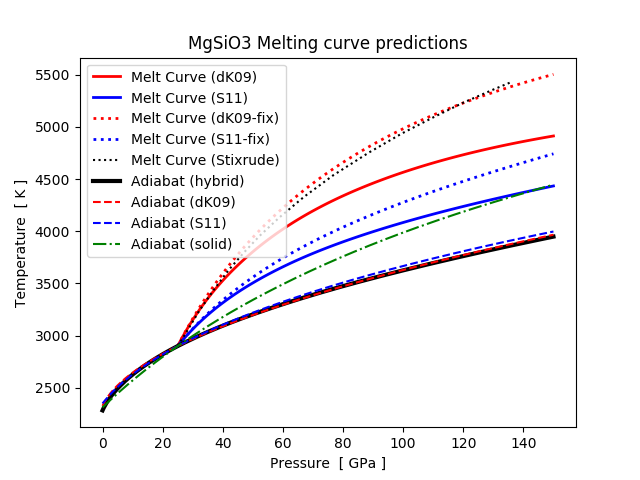

In [8]:
plt.figure()
plt.plot(P_fus_dK09, T_fus_dK09, 'r-', lw=2, label='Melt Curve (dK09)')
plt.plot(P_fus_S11, T_fus_S11, 'b-', lw=2, label='Melt Curve (S11)')

plt.plot(P_fus_dK09_fix, T_fus_dK09_fix, 'r:', lw=2, label='Melt Curve (dK09-fix)')
plt.plot(P_fus_S11_fix, T_fus_S11_fix, 'b:', lw=2, label='Melt Curve (S11-fix)')

plt.plot(PT_fus_Stx09['P'], PT_fus_Stx09['T'], 'k:', label='Melt Curve (Stixrude)')


plt.plot(P_ad_hybrid, T_ad_hybrid, 'k-', lw=3, label='Adiabat (hybrid)')
plt.plot(P_ad_dK09, T_ad_dK09, 'r--', label='Adiabat (dK09)')
plt.plot(P_ad_S11, T_ad_S11, 'b--', label='Adiabat (S11)')
plt.plot(P_sol_ad, T_sol_ad, 'g-.', label='Adiabat (solid)')


plt.title('MgSiO3 Melting curve predictions')
plt.xlabel('Pressure  [ GPa ]')
plt.ylabel('Temperature  [ K ]')
plt.legend()

In [9]:


S_fus_liq_S11 = liq_eos_S11.entropy(V_fus_liq_S11, T_fus_S11) 
S_fus_sol_S11 = sol_eos.entropy(V_fus_sol_S11, T_fus_S11) 
dS_fus_S11 = (S_fus_liq_S11-S_fus_sol_S11)/xmeos.models.CONSTS['kboltz']

S_fus_liq_dK09 = liq_eos_dK09.entropy(V_fus_liq_dK09, T_fus_dK09) 
S_fus_sol_dK09 = sol_eos.entropy(V_fus_sol_dK09, T_fus_dK09)
dS_fus_dK09 = (S_fus_liq_dK09-S_fus_sol_dK09)/xmeos.models.CONSTS['kboltz']



<IPython.core.display.Javascript object>


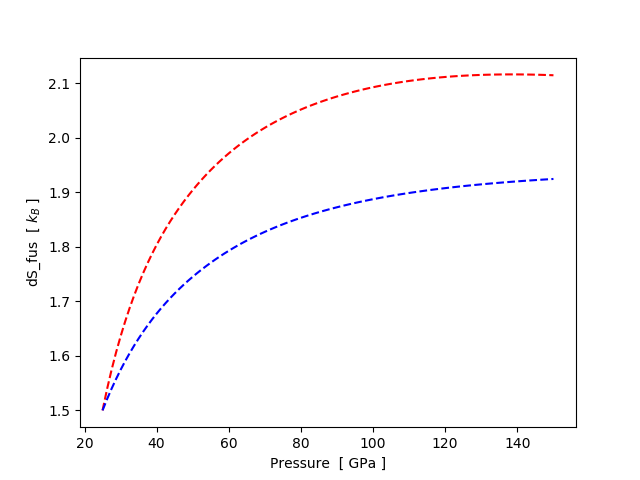

In [10]:

plt.figure()

plt.plot(P_fus_dK09, dS_fus_dK09, 'r--')
plt.plot(P_fus_S11, dS_fus_S11, 'b--')

plt.xlabel('Pressure  [ GPa ]')
plt.ylabel('dS_fus  [ $k_B$ ]')
